# Exoplanet Classification with Naive Bayes

Between habitable and non-habitable

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB

In [2]:
pd.set_option('display.expand_frame_repr', True)

Data from http://exoplanet.eu/catalog/

Showing 5346 objects

**Goal**: implement NB to classify into habitable and not habitable

In [3]:
exoplanets = pd.read_csv('exoplanet_catalog.csv')
exoplanets

,name,planet_status,mass,mass_error_min,mass_error_max,mass_sini,mass_sini_error_min,mass_sini_error_max,radius,radius_error_min,...,star_sp_type,star_age,star_age_error_min,star_age_error_max,star_teff,star_teff_error_min,star_teff_error_max,star_detected_disc,star_magnetic_field,star_alternate_names
0,11 Com b,Confirmed,NaN,NaN,NaN,16.1284,1.53491,1.53491,NaN,NaN,...,G8 III,NaN,NaN,NaN,4742.0,100.0,100.0,NaN,NaN,NaN
1,11 Oph b,Confirmed,21.000,3.00,3.000,NaN,NaN,NaN,NaN,NaN,...,M9,0.011,0.002,0.002,2375.0,175.0,175.0,NaN,NaN,"Oph 1622-2405, Oph 11A"
2,11 UMi b,Confirmed,NaN,NaN,NaN,11.0873,1.10000,1.10000,NaN,NaN,...,K4III,1.560,0.540,0.540,4340.0,70.0,70.0,NaN,NaN,NaN
3,14 And b,Confirmed,NaN,NaN,NaN,4.6840,0.23000,0.23000,NaN,NaN,...,K0III,NaN,NaN,NaN,4813.0,20.0,20.0,NaN,NaN,NaN
4,14 Her b,Confirmed,9.653,1.67,2.331,5.2150,0.30000,0.30000,NaN,NaN,...,K0 V,5.100,NaN,NaN,5311.0,87.0,87.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5341,ups And c,Confirmed,9.100,2.93,5.040,1.8000,0.26000,0.26000,NaN,NaN,...,F8 V,3.800,1.000,1.000,6212.0,80.0,80.0,NaN,NaN,NaN
5342,ups And d,Confirmed,23.580,2.29,2.930,10.1900,NaN,NaN,NaN,NaN,...,F8 V,3.800,1.000,1.000,6212.0,80.0,80.0,NaN,NaN,NaN
5343,ups And e,Confirmed,NaN,NaN,NaN,1.0590,0.02800,0.02800,NaN,NaN,...,F8 V,3.800,1.000,1.000,6212.0,80.0,80.0,NaN,NaN,NaN
5344,ups Leo b,Confirmed,NaN,NaN,NaN,0.5100,0.26000,0.08000,NaN,NaN,...,G9 III,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
exoplanets.columns

Index(['name', 'planet_status', 'mass', 'mass_error_min', 'mass_error_max',
       'mass_sini', 'mass_sini_error_min', 'mass_sini_error_max', 'radius',
       'radius_error_min', 'radius_error_max', 'orbital_period',
       'orbital_period_error_min', 'orbital_period_error_max',
       'semi_major_axis', 'semi_major_axis_error_min',
       'semi_major_axis_error_max', 'eccentricity', 'eccentricity_error_min',
       'eccentricity_error_max', 'inclination', 'inclination_error_min',
       'inclination_error_max', 'angular_distance', 'discovered', 'updated',
       'omega', 'omega_error_min', 'omega_error_max', 'tperi',
       'tperi_error_min', 'tperi_error_max', 'tconj', 'tconj_error_min',
       'tconj_error_max', 'tzero_tr', 'tzero_tr_error_min',
       'tzero_tr_error_max', 'tzero_tr_sec', 'tzero_tr_sec_error_min',
       'tzero_tr_sec_error_max', 'lambda_angle', 'lambda_angle_error_min',
       'lambda_angle_error_max', 'impact_parameter',
       'impact_parameter_error_min', 'impa

## Define Labels

### Habitable Zone

This __[GitHub](https://github.com/ageller/HZ_Kopparapu)__ implements a function to define the habitable zone of a stellar system with exoplanets as defined by __[Kopparapu et al. 2013](https://ui.adsabs.harvard.edu/abs/2013ApJ...765..131K/abstract)__, and they also provide the needed coefficients.

In [5]:
def getHZ(L, T, inC, outC):

    # L == luminosity of the star 
    # T == effective temperature of the star
    # inC and outC == the relevant inner and outer coefficients list, from Kopparapu's Table 3
    # these coefficients are supplied in the HZ_coefficients.dat file"
    
    Lstar = L  #.value_in(units.LSun)
    Tstar = T  #.value_in(units.K)

    #Kopparapu HZ
    tst = Tstar - 5780.0
    #THIS IS THE LIMIT OF THE Kopparapu results.  Not sure what to do outside of this!
    if (Tstar > 7200): 
        print("!!!WARNING: Teff > 7200 K -- outside of Kopparapu model limits -- setting Tstar=7200-5780")
        tst = 7200. - 5780.
    if (Tstar < 2600): 
        print("!!!WARNING: Teff < 2600 K -- outside of Kopparapu model limits -- setting Tstar=2600-5780")
        tst = 2600. - 5780.
    Seff_inRK = inC[0] + inC[1]*tst + inC[2]*tst**2 + inC[3]*tst**3 + inC[4]*tst**4
    Seff_outRK = outC[0] + outC[1]*tst + outC[2]*tst**2 + outC[3]*tst**3 + outC[4]*tst**4
    dinRK = np.sqrt(Lstar / Seff_inRK) #| units.AU
    doutRK = np.sqrt(Lstar / Seff_outRK) #| units.AU

    return dinRK, doutRK

In [6]:
HZdf = pd.read_csv("HZ_coefficients.dat", sep = ' ', skipinitialspace = True, skiprows = 13, 
              names = ['S1','S2','S3','S4','S5'])
HZdf

,S1,S2,S3,S4,S5
0,1.775300e+00,1.051200e+00,1.014000e+00,3.438000e-01,3.179000e-01
1,1.431600e-04,1.324200e-04,8.177400e-05,5.894200e-05,5.451300e-05
2,2.987500e-09,1.541800e-08,1.706300e-09,1.655800e-09,1.531300e-09
3,-7.570200e-12,-7.989500e-12,-4.324100e-12,-3.004500e-12,-2.778600e-12
4,-1.163500e-15,-1.832800e-15,-6.646200e-16,-5.298300e-16,-4.899700e-16


### Semi-Minor Axis

\begin{align}
    e = \sqrt{1 - \frac{b^2}{a^2}}
\end{align}

In [7]:
def semi_minor_axis(a, e):
    '''
    a: semi-major axis
    e: eccentricity
    '''
    return a * np.sqrt(1 - e**2)

In [8]:
exoplanets['eccentricity'].describe()

count    2163.000000
mean        0.165130
std         0.199494
min         0.000000
25%         0.019000
50%         0.100000
75%         0.244750
max         3.155000
Name: eccentricity, dtype: float64

In [9]:
exoplanets.shape

(5346, 98)

In [10]:
exoplanets.drop(exoplanets.loc[exoplanets['eccentricity'] >= 1].index, inplace=True)

In [11]:
exoplanets.shape

(5344, 98)

In [12]:
exoplanets['eccentricity'].describe()

count    2161.000000
mean        0.163270
std         0.187619
min         0.000000
25%         0.019000
50%         0.100000
75%         0.240000
max         0.970000
Name: eccentricity, dtype: float64

In [13]:
exoplanets['semi_minor_axis'] = exoplanets.apply(lambda x: semi_minor_axis(x['semi_major_axis'], x['eccentricity']), axis=1)

### Luminosity

For stars in the main sequence:
\begin{align}
    L \propto M^{3.5}
\end{align}

In [14]:
exoplanets['star_lum'] = exoplanets.apply(lambda x: x['star_mass']**(3.5), axis=1)

In [15]:
exoplanets['star_lum'].describe()

count    4.772000e+03
mean     9.710860e+00
std      5.190758e+02
min      1.395965e-07
25%      4.191130e-01
50%      8.356658e-01
75%      1.395965e+00
max      3.577709e+04
Name: star_lum, dtype: float64

### Calculate HZ

Between Runaway Greenhouse and Maximum Greenhouse: `S2` and `S4` coefficients.

In [16]:
exoplanets.drop(exoplanets.loc[exoplanets['star_teff'] <= 2600].index, inplace=True)
exoplanets.drop(exoplanets.loc[exoplanets['star_teff'] >= 7200].index, inplace=True)

In [17]:
exoplanets.shape

(5253, 100)

In [18]:
exoplanets['inner_HZ'] = exoplanets.apply(lambda x: getHZ(x['star_lum'], x['star_teff'], HZdf['S1'], HZdf['S5'])[0], axis=1)
exoplanets['outer_HZ'] = exoplanets.apply(lambda x: getHZ(x['star_lum'], x['star_teff'], HZdf['S1'], HZdf['S5'])[1], axis=1)

In [19]:
exoplanets[['inner_HZ', 'semi_minor_axis', 'outer_HZ', 'semi_major_axis']].describe()

,inner_HZ,semi_minor_axis,outer_HZ,semi_major_axis
count,4282.000000,2010.000000,4282.000000,3528.000000
mean,0.763551,1.329281,1.825948,23.257720
std,0.486847,11.970238,1.179238,313.954454
min,0.000620,0.003997,0.001654,0.002600
25%,0.529395,0.049900,1.300804,0.053800
50%,0.701846,0.124252,1.668590,0.116100
75%,0.893244,1.052280,2.098607,0.846750
max,10.236054,509.582417,26.137555,9900.000000


### Set labels

In [20]:
def habitable(inner_HZ, outer_HZ, semi_minor_axis, semi_major_axis):
    
    if (semi_minor_axis >= inner_HZ) and (semi_major_axis <= outer_HZ):
        label = 'habitable'
    else:
        label = 'non-habitable'

    return label

In [21]:
exoplanets['label'] = exoplanets.apply(lambda x: habitable(x['inner_HZ'], x['outer_HZ'], 
                                                           x['semi_minor_axis'], x['semi_major_axis']), 
                                                           axis=1)

In [22]:
Counter(exoplanets['label'])

Counter({'non-habitable': 5026, 'habitable': 227})

In [23]:
exoplanets[['mass', 'omega', 'tperi', 'tconj', 'tzero_tr', 'k', 'temp_calculated', 
            'temp_measured', 'geometric_albedo', 'log_g', 'mag_v', 'mag_j', 'mag_h', 
            'mag_k', 'star_distance', 'star_metallicity', 'star_mass', 'star_radius', 
            'star_age', 'star_teff']].describe()

,mass,omega,tperi,tconj,tzero_tr,k,temp_calculated,temp_measured,geometric_albedo,log_g,mag_v,mag_j,mag_h,mag_k,star_distance,star_metallicity,star_mass,star_radius,star_age,star_teff
count,1784.000000,1337.000000,7.740000e+02,2.655000e+03,1.273000e+03,1349.000000,1141.000000,44.000000,15.000000,44.000000,2238.000000,2909.00000,2902.000000,2215.000000,4953.000000,4266.000000,4689.000000,4389.000000,2827.000000,4562.000000
mean,5.704875,168.622899,2.124186e+06,2.452829e+06,2.466684e+06,254.723221,1006.863821,1588.525000,0.236867,4.255023,10.589408,12.63728,12.248203,12.450653,702.523299,-0.004960,0.943699,1.547046,4.253231,5344.358415
std,12.624073,108.944928,8.287744e+05,7.720527e+04,6.331652e+05,1952.827839,529.856142,826.521409,0.231668,0.579638,3.194130,1.54674,1.552426,1.480413,1179.155681,0.201033,0.367185,3.724574,2.514317,795.242204
min,0.000063,-163.000000,1.236000e+03,5.876892e+00,2.450000e+02,-2.840000,110.000000,84.000000,0.000000,2.734000,0.850000,2.85000,2.040000,2.170000,1.295000,-1.080000,0.011000,0.008300,0.000500,2620.000000
25%,0.045992,79.600000,2.451358e+06,2.454968e+06,2.455003e+06,3.500000,586.000000,1030.000000,0.080000,3.987500,8.050000,11.90200,11.516250,11.956500,96.000000,-0.100000,0.780000,0.780000,2.725000,4954.000000
50%,0.660000,162.000000,2.454427e+06,2.454981e+06,2.456894e+06,29.220000,903.000000,1356.000000,0.160000,4.275000,10.700000,12.93900,12.555000,12.706000,395.450000,0.010000,0.950000,0.960000,4.070000,5550.000000
75%,3.235000,263.600000,2.455962e+06,2.455023e+06,2.458326e+06,108.000000,1397.000000,2325.000000,0.360000,4.732500,12.872500,13.74100,13.317500,13.372000,843.120000,0.110000,1.100000,1.250000,5.010000,5900.000000
max,82.000000,360.000000,2.476000e+06,2.577713e+06,2.454889e+07,48800.000000,3365.000000,3631.000000,0.785000,5.150000,24.000000,19.60000,23.380000,15.400000,11000.000000,0.560000,6.500000,88.500000,15.000000,7175.000000


## Prepare dataset

In [24]:
columns = ['mass', 'omega', 'tperi', 'tconj', 'tzero_tr', 'k', 'temp_calculated', 
            'temp_measured', 'geometric_albedo', 'log_g', 'mag_v', 'mag_j', 'mag_h', 
            'mag_k', 'star_distance', 'star_metallicity', 'star_mass', 'star_radius', 
            'star_age', 'star_teff', 'label']

In [25]:
exop_NB = exoplanets[columns]

exop_NB

,mass,omega,tperi,tconj,tzero_tr,k,temp_calculated,temp_measured,geometric_albedo,log_g,...,mag_j,mag_h,mag_k,star_distance,star_metallicity,star_mass,star_radius,star_age,star_teff,label
0,NaN,94.800,2452899.600,NaN,NaN,302.800,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,110.60,-0.35,2.70,19.000,NaN,4742.0,non-habitable
2,NaN,117.630,2452861.050,NaN,NaN,189.700,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,119.50,0.04,1.80,24.080,1.56,4340.0,non-habitable
3,NaN,NaN,2452861.400,NaN,NaN,100.000,NaN,NaN,NaN,NaN,...,3.02,2.61,2.33,76.40,-0.24,2.20,11.000,NaN,4813.0,non-habitable
4,9.653,22.780,2451372.700,NaN,NaN,90.000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,18.10,0.43,0.90,0.708,5.10,5311.0,non-habitable
5,6.900,15.200,9100.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,18.10,0.43,0.90,0.708,5.10,5311.0,non-habitable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5340,0.620,44.519,2450034.058,NaN,NaN,70.519,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,13.47,0.09,1.27,1.631,3.80,6212.0,non-habitable
5341,9.100,247.629,2449922.548,NaN,NaN,53.498,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,13.47,0.09,1.27,1.631,3.80,6212.0,non-habitable
5342,23.580,252.991,2450059.072,NaN,NaN,67.700,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,13.47,0.09,1.27,1.631,3.80,6212.0,habitable
5343,NaN,7.300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,13.47,0.09,1.27,1.631,3.80,6212.0,non-habitable


In [26]:
for col in columns:
    if col=='label':
        pass
    else:
        exop_NB[col] = exop_NB[col].fillna(exop_NB[col].mean())

/Users/nicolasgalvarinoguerravaras/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [27]:
exop_NB

,mass,omega,tperi,tconj,tzero_tr,k,temp_calculated,temp_measured,geometric_albedo,log_g,...,mag_j,mag_h,mag_k,star_distance,star_metallicity,star_mass,star_radius,star_age,star_teff,label
0,5.704875,94.800000,2.452900e+06,2.452829e+06,2.466684e+06,302.800000,1006.863821,1588.525,0.236867,4.255023,...,12.63728,12.248203,12.450653,110.600000,-0.35000,2.700000,19.000000,4.253231,4742.000000,non-habitable
2,5.704875,117.630000,2.452861e+06,2.452829e+06,2.466684e+06,189.700000,1006.863821,1588.525,0.236867,4.255023,...,12.63728,12.248203,12.450653,119.500000,0.04000,1.800000,24.080000,1.560000,4340.000000,non-habitable
3,5.704875,168.622899,2.452861e+06,2.452829e+06,2.466684e+06,100.000000,1006.863821,1588.525,0.236867,4.255023,...,3.02000,2.610000,2.330000,76.400000,-0.24000,2.200000,11.000000,4.253231,4813.000000,non-habitable
4,9.653000,22.780000,2.451373e+06,2.452829e+06,2.466684e+06,90.000000,1006.863821,1588.525,0.236867,4.255023,...,12.63728,12.248203,12.450653,18.100000,0.43000,0.900000,0.708000,5.100000,5311.000000,non-habitable
5,6.900000,15.200000,9.100000e+03,2.452829e+06,2.466684e+06,254.723221,1006.863821,1588.525,0.236867,4.255023,...,12.63728,12.248203,12.450653,18.100000,0.43000,0.900000,0.708000,5.100000,5311.000000,non-habitable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5340,0.620000,44.519000,2.450034e+06,2.452829e+06,2.466684e+06,70.519000,1006.863821,1588.525,0.236867,4.255023,...,12.63728,12.248203,12.450653,13.470000,0.09000,1.270000,1.631000,3.800000,6212.000000,non-habitable
5341,9.100000,247.629000,2.449923e+06,2.452829e+06,2.466684e+06,53.498000,1006.863821,1588.525,0.236867,4.255023,...,12.63728,12.248203,12.450653,13.470000,0.09000,1.270000,1.631000,3.800000,6212.000000,non-habitable
5342,23.580000,252.991000,2.450059e+06,2.452829e+06,2.466684e+06,67.700000,1006.863821,1588.525,0.236867,4.255023,...,12.63728,12.248203,12.450653,13.470000,0.09000,1.270000,1.631000,3.800000,6212.000000,habitable
5343,5.704875,7.300000,2.124186e+06,2.452829e+06,2.466684e+06,254.723221,1006.863821,1588.525,0.236867,4.255023,...,12.63728,12.248203,12.450653,13.470000,0.09000,1.270000,1.631000,3.800000,6212.000000,non-habitable


In [28]:
x = exop_NB.drop('label', axis=1)
y = exop_NB['label']

### Saving

In [37]:
# exop_NB.to_csv('exoplanet_data_processed.csv', index=False)

### Normalizing & Scaling

In [29]:
x_norm = normalize(X=x)
x_norm

array([[1.34027927e-06, 2.22719120e-05, 5.76273881e-01, ...,
        4.46377982e-06, 9.99236224e-07, 1.11406547e-03],
       [1.34028640e-06, 2.76356429e-05, 5.76267891e-01, ...,
        5.65728369e-06, 3.66501767e-07, 1.01962671e-03],
       [1.34028618e-06, 3.96157565e-05, 5.76267878e-01, ...,
        2.58430690e-06, 9.99241375e-07, 1.13075174e-03],
       ...,
       [5.54191368e-06, 5.94594692e-05, 5.75827646e-01, ...,
        3.83327447e-07, 8.93098897e-07, 1.45998167e-03],
       [1.39965395e-06, 1.79100747e-06, 5.21155301e-01, ...,
        4.00155232e-07, 9.32305261e-07, 1.52407376e-03],
       [1.33984716e-06, 3.07666648e-05, 5.76647057e-01, ...,
        3.63339242e-07, 9.98914069e-07, 1.25517621e-03]])

In [30]:
scaler = MinMaxScaler()
x_ready = scaler.fit_transform(x_norm)

### Splitting

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x_ready, y, test_size=0.3, stratify=y, random_state=42)

In [32]:
len(y_train)

3677

In [33]:
x_train.shape

(3677, 20)

In [34]:
len(y_test)

1576

In [35]:
x_test.shape

(1576, 20)

### Training

In [169]:
model = ComplementNB()
model.fit(x_train, y_train)

ComplementNB()

In [171]:
y_pred = model.predict(x_test)

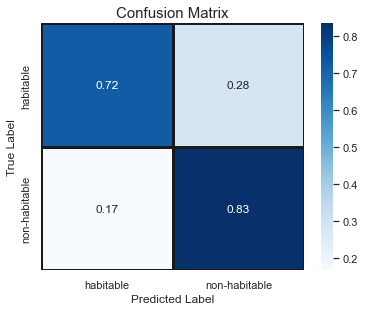

In [173]:
plt.figure(figsize=(13, 10))
plt.subplot(221)

sns.heatmap(confusion_matrix(y_test, model.predict(x_test), normalize='true'), 
            annot=True, cmap="Blues", linecolor="k", linewidths=3, 
            xticklabels=['habitable', 'non-habitable'], 
            yticklabels=['habitable', 'non-habitable'])

plt.title("Confusion Matrix", fontsize=15)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()